In [1]:
import platform
platform.system()

'Windows'

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
from numpy.linalg import multi_dot

from scipy.stats import norm
from tabulate import tabulate

# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt

# Plot settings
plt.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = [24.0, 8.0]
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rcParams['grid.color'] = 'black'

from helper import plot_var

In [3]:
# Load locally stored data
df = pd.read_csv('nasdaqstocks.csv', index_col=0, parse_dates=True)

# Check values 
df


,AMD,CSCO,INTC,INTU,NVDA
Date,,,,,
2017-01-03,11.430000,25.985624,31.973000,110.028526,25.166451
2017-01-04,11.430000,25.831152,31.807018,110.249046,25.753607
2017-01-05,11.240000,25.891224,31.754604,110.929825,25.099840
2017-01-06,11.320000,25.942715,31.868174,112.381981,25.435360
2017-01-09,11.490000,25.899811,31.981735,112.045395,26.466593
...,...,...,...,...,...
2021-12-23,146.139999,61.915154,50.922092,634.972839,296.349487
2021-12-27,154.360001,63.048477,51.547329,652.013062,309.397308
2021-12-28,153.149994,63.157833,51.368690,649.026550,303.168335


In [4]:
# Calculate daily returns
returns = df.pct_change().dropna()
returns.head()

,AMD,CSCO,INTC,INTU,NVDA
Date,,,,,
2017-01-04,0.000000,-0.005945,-0.005191,0.002004,0.023331
2017-01-05,-0.016623,0.002326,-0.001648,0.006175,-0.025385
2017-01-06,0.007117,0.001989,0.003576,0.013091,0.013367
2017-01-09,0.015018,-0.001654,0.003563,-0.002995,0.040543
2017-01-10,-0.004352,0.006627,-0.001912,-0.003433,-0.007550


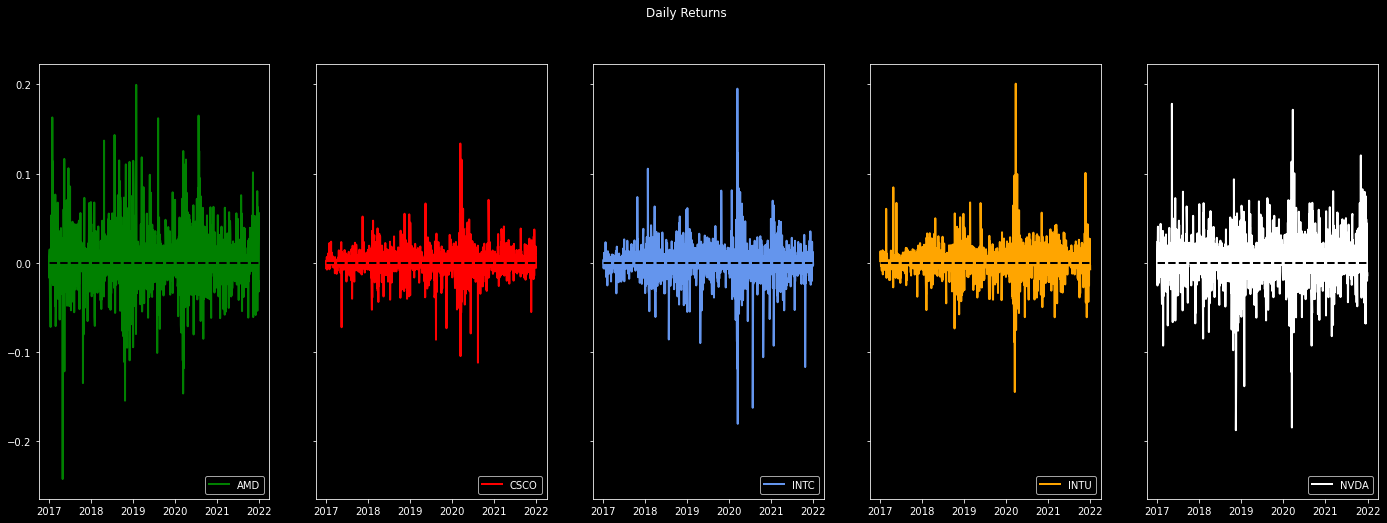

In [8]:
# Visualize daily returns
fig, ax = plt.subplots(1,len(df.columns), sharey=True)
label, color = df.columns, ['green', 'red', 'cornflowerblue', 'orange', 'white']

for i in range(len(df.columns)):
    ax[i].plot(returns.iloc[:,i], label=label[i], color=color[i])
    ax[i].axhline(y=0, color='k', linestyle='--')
    ax[i].legend(loc=4)

fig.suptitle('Daily Returns');

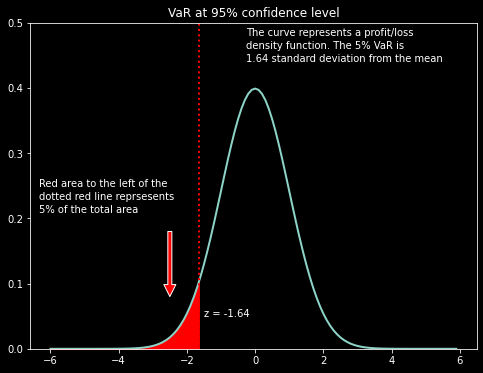

In [5]:
# Visualize VaR at 95% confidence level
plot_var()

In [6]:
# Calculate mean and standard deviation 
mean = np.mean(returns['AMD'])
stdev = np.std(returns['AMD'])

# Calculate VaR at difference confidence level
VaR_90 = norm.ppf(1-0.90,mean,stdev)
VaR_95 = norm.ppf(1-0.95,mean,stdev) 
VaR_99 = norm.ppf(1-0.99,mean,stdev)

In [9]:
# number of stdev from the mean
norm.ppf(0.05)

-1.6448536269514729

In [10]:
# Ouput results in tabular format
table = [['90%', VaR_90],['95%', VaR_95],['99%', VaR_99] ]
header = ['Confidence Level', 'Value At Risk']
print(tabulate(table,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0427205
95%                      -0.0555824
99%                      -0.0797091


In [11]:
# VaR function
def VaR(dataframe):
    var = pd.DataFrame()

    for i in [90, 95, 99]:
        for j in range(len(df.columns)):
            var.loc[i, j] = 100 * norm.ppf(1-i/100, dataframe.iloc[:,j].mean(), dataframe.iloc[:,j].std())

    var.columns = df.columns
    return var

In [12]:
# VaR for stocks
VaR(returns)

,AMD,CSCO,INTC,INTU,NVDA
90,-4.273859,-2.101121,-2.739468,-2.341609,-3.558122
95,-5.560556,-2.720966,-3.533578,-3.050609,-4.634949
99,-7.974186,-3.883691,-5.023198,-4.380576,-6.654897


In [14]:
num_of_shares = 1000
price = df['AMD'].iloc[-1]
position = num_of_shares * price 

amd_var = position * -VaR_99

print(f'AMD Holding Value: {position}')
print(f'AMD VaR at 99% confidence level is: {amd_var}')

AMD Holding Value: 145149.994
AMD VaR at 99% confidence level is: 11569.771998178152


In [16]:
# VaR calculation by appling direct formulae
position * (mean + norm.ppf(0.99) * stdev)         # mean-2.33*stdev

12339.002235289827

In [17]:
# Use quantile function for Historical VaR
hVaR_90 = returns['AMD'].quantile(0.10)
hVaR_95 = returns['AMD'].quantile(0.05)
hVaR_99 = returns['AMD'].quantile(0.01)

In [18]:
htable = [['90%', hVaR_90],['95%', hVaR_95],['99%', hVaR_99]]
print(tabulate(htable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0334636
95%                      -0.0504089
99%                      -0.0887104


In [19]:
# Set seed for reproducibility
np.random.seed(52)

# Number of simulations
n_sims = 5000

# Simulate returns and sort
sim_returns = np.random.normal(mean, stdev, n_sims)

# Use percentile function for MCVaR
MCVaR_90 = np.percentile(sim_returns,10)
MCVaR_95 = np.percentile(sim_returns, 5)
MCVaR_99 = np.percentile(sim_returns,1)

In [20]:
mctable = [['90%', MCVaR_90],['95%', MCVaR_95],['99%', MCVaR_99]]
print(tabulate(mctable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0429576
95%                      -0.0557679
99%                      -0.0810496


In [21]:
forecast_days = 5
f_VaR_90 = VaR_90*np.sqrt(forecast_days)
f_VaR_95 = VaR_95*np.sqrt(forecast_days)
f_VaR_99 = VaR_99*np.sqrt(forecast_days)

In [22]:
ftable = [['90%', f_VaR_90],['95%', f_VaR_95],['99%', f_VaR_99] ]
fheader = ['Confidence Level', '5-Day Forecast Value At Risk']
print(tabulate(ftable,headers=fheader))

Confidence Level      5-Day Forecast Value At Risk
------------------  ------------------------------
90%                                      -0.095526
95%                                      -0.124286
99%                                      -0.178235


In [23]:
amd_var_5days = position * f_VaR_99

print(f'AMD Holding Value: {position}')
print(f'AMD VaR at 99% confidence level is: {amd_var_5days}')

AMD Holding Value: 145149.994
AMD VaR at 99% confidence level is: -25870.79667209992


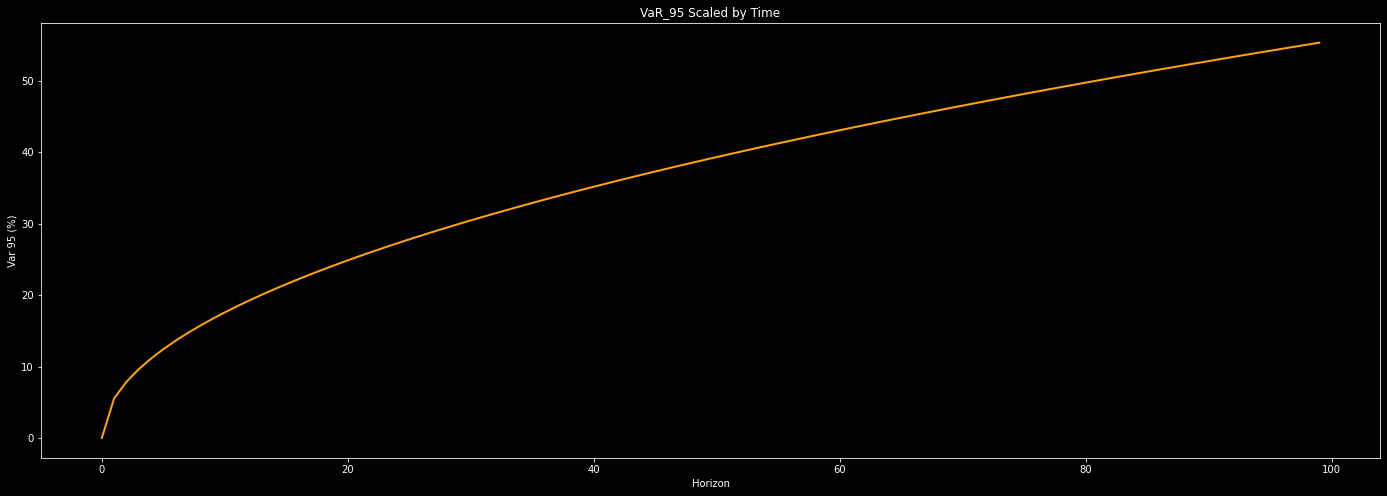

In [24]:
# Scaled VaR over different time horizon
# plt.figure()
plt.plot(range(100),[-100*VaR_95*np.sqrt(x) for x in range(100)], color='orange')
plt.xlabel('Horizon')
plt.ylabel('Var 95 (%)')
plt.title('VaR_95 Scaled by Time');

In [25]:
# Calculate CVar
CVaR_90 = returns['AMD'][returns['AMD']<=hVaR_90].mean()
CVaR_95 = returns['AMD'][returns['AMD']<=hVaR_95].mean()
CVaR_99 = returns['AMD'][returns['AMD']<=hVaR_99].mean()

In [26]:
ctable = [['90%', CVaR_90],['95%', CVaR_95],['99%', CVaR_99] ]
cheader = ['Confidence Level', 'Conditional Value At Risk']
print(tabulate(ctable,headers=cheader))

Confidence Level      Conditional Value At Risk
------------------  ---------------------------
90%                                  -0.0585997
95%                                  -0.0768405
99%                                  -0.125374


In [27]:
# Weights from Minimum Variance Portfolio
weights = pd.DataFrame([0., 57.70, 13.14, 29.16, 0.0]).T
weights.columns = df.columns
weights

,AMD,CSCO,INTC,INTU,NVDA
0,0.0,57.7,13.14,29.16,0.0


In [28]:
# Portfolio returns
port_ret = np.dot(returns, weights.T)
port_mean = port_ret.mean()
port_mean

0.10386424454190814

In [29]:
# Portfolio volatility
port_stdev = np.sqrt(multi_dot([weights, returns.cov(), weights.T]))
port_stdev.flatten()[0]

1.5879430754757125

In [30]:
# Calculate Portfolio VaR at difference confidence level
pVaR_90 = norm.ppf(1-0.90,port_mean,port_stdev).flatten()[0]
pVaR_95 = norm.ppf(1-0.95,port_mean,port_stdev).flatten()[0]
pVaR_99 = norm.ppf(1-0.99,port_mean,port_stdev).flatten()[0]

In [31]:
# Ouput results in tabular format
ptable = [['90%', pVaR_90],['95%', pVaR_95],['99%', pVaR_99]]
header = ['Confidence Level', 'Value At Risk']
print(tabulate(ptable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                        -1.93117
95%                        -2.50807
99%                        -3.59024


In [32]:
# Iterate over symbols
portpos=0.
for stock in df.columns:
    pos = df[stock].iloc[-1] * 1000*weights[stock][0]
    pvar = VaR(returns)[stock].iloc[1]

    print(f'{stock} Holding Value: {pos:0.8}') 
    print(f'{stock} VaR at 95% confidence level: {pvar:0.8}%')
    print()

    portpos += pos

print(f'Portfolio Holding Value: {portpos:0.8}')
print(f'Portoflio VaR at 95% confidence level: {pVaR_95:0.3}%')

AMD Holding Value: 0.0
AMD VaR at 95% confidence level: -5.5605559%

CSCO Holding Value: 3649369.6
CSCO VaR at 95% confidence level: -2.7209659%

INTC Holding Value: 674723.8
INTC VaR at 95% confidence level: -3.5335782%

INTU Holding Value: 1.8738623e+07
INTU VaR at 95% confidence level: -3.0506092%

NVDA Holding Value: 0.0
NVDA VaR at 95% confidence level: -4.6349486%

Portfolio Holding Value: 2.3062716e+07
Portoflio VaR at 95% confidence level: -2.51%
